# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

How do energy prices change throughout the year? Are there any patterns by season or month of the year?

# EDA for energy prices in Melbourne, Australia

## Import packages

In [103]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [104]:
# Import data

In [105]:
df = pd.read_csv('https://raw.githubusercontent.com/KamgangAnthony/Predicting-Electricity-Price-Levels-/main/complete_dataset.csv')
mapping_columns = {"RRP":"price", "demand_pos_RRP":"demand_pos_price", "RRP_positive":"price_positive", "demand_neg_RRP":"demand_neg_price", "RRP_negative":"price_negative", "frac_at_neg_RRP":"frac_neg_price"}
df.rename(columns = mapping_columns, inplace = True)

In [106]:
df.head(10)

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
5,2015-01-06,130672.485,31.282311,130672.485,31.282311,0.000,0.000000,0.000000,17.7,26.0,31.6,0.0,N,N
6,2015-01-07,153514.820,48.312309,149498.715,49.639712,4016.105,-1.100000,0.020833,18.9,37.4,20.7,0.0,N,N
7,2015-01-08,142015.655,49.117280,142015.655,49.117280,0.000,0.000000,0.000000,23.1,28.2,13.5,19.4,N,N
8,2015-01-09,121801.155,34.490675,121801.155,34.490675,0.000,0.000000,0.000000,16.5,18.0,3.1,1.2,N,N
9,2015-01-10,103043.660,20.229825,103043.660,20.229825,0.000,0.000000,0.000000,13.6,21.7,5.6,5.2,N,N


## Preprocess data

In [107]:
df.date = pd.to_datetime(df.date)
df.school_day = df.school_day.map({"N": False, "Y":True}).astype('bool')
df.holiday = df.holiday.map({"N": False, "Y":True}).astype('bool')

#We extract the year, month and day of the week from the data
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dow'] = df.date.dt.day_of_week

df.set_index('date', inplace =True)

In [108]:
df.head(10)

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,dow
date,,,,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,False,True,2015,1,3
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,False,False,2015,1,4
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,False,False,2015,1,5
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,False,False,2015,1,6
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,False,False,2015,1,0
2015-01-06,130672.485,31.282311,130672.485,31.282311,0.000,0.000000,0.000000,17.7,26.0,31.6,0.0,False,False,2015,1,1
2015-01-07,153514.820,48.312309,149498.715,49.639712,4016.105,-1.100000,0.020833,18.9,37.4,20.7,0.0,False,False,2015,1,2
2015-01-08,142015.655,49.117280,142015.655,49.117280,0.000,0.000000,0.000000,23.1,28.2,13.5,19.4,False,False,2015,1,3
2015-01-09,121801.155,34.490675,121801.155,34.490675,0.000,0.000000,0.000000,16.5,18.0,3.1,1.2,False,False,2015,1,4


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015-01-01 to 2020-10-06
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   demand            2106 non-null   float64
 1   price             2106 non-null   float64
 2   demand_pos_price  2106 non-null   float64
 3   price_positive    2106 non-null   float64
 4   demand_neg_price  2106 non-null   float64
 5   price_negative    2106 non-null   float64
 6   frac_neg_price    2106 non-null   float64
 7   min_temperature   2106 non-null   float64
 8   max_temperature   2106 non-null   float64
 9   solar_exposure    2105 non-null   float64
 10  rainfall          2103 non-null   float64
 11  school_day        2106 non-null   bool   
 12  holiday           2106 non-null   bool   
 13  year              2106 non-null   int64  
 14  month             2106 non-null   int64  
 15  dow               2106 non-null   int64  
dtypes: bool(2), float64(11),

# Information derived from the description below

The average price is 76AUD/MWh. throughout the years. 
There has not being a great deviation to this price throughout the years. 

The solar exposure varies greatly and approaches 0 on certain days.

We need not worry too much about negative prices because generally they only occur in some days and during 0.9% of the day averagely when they do.

We may want to pay attention to the demand_neg_price which can reach a maximum of 57597MWh daily.

In [110]:
df.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,year,month,dow
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000,2106.000000,2106.000000,2106.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944,2017.398386,6.336182,3.000475
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897,1.665174,3.388396,2.000831
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000,2015.000000,1.000000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000,2016.000000,3.000000,1.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000,2017.000000,6.000000,3.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000,2019.000000,9.000000,5.000000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000,2020.000000,12.000000,6.000000


## Graphs over time 
### Demand over time
The mean demand varies greatly throughout the year. Although it is affected by other conditions, it still respects it's peaks in the middle of the year(winter period).

Text(0, 0.5, 'Demand / MWh')

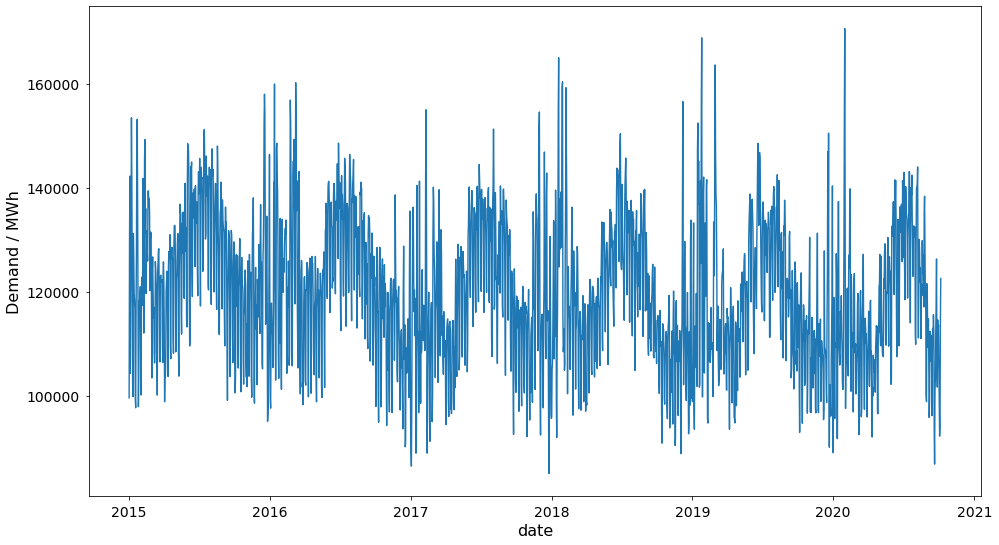

In [111]:
ax = sns.lineplot(data = df, x = 'date', y = 'demand')
ax.set_ylabel('Demand / MWh')

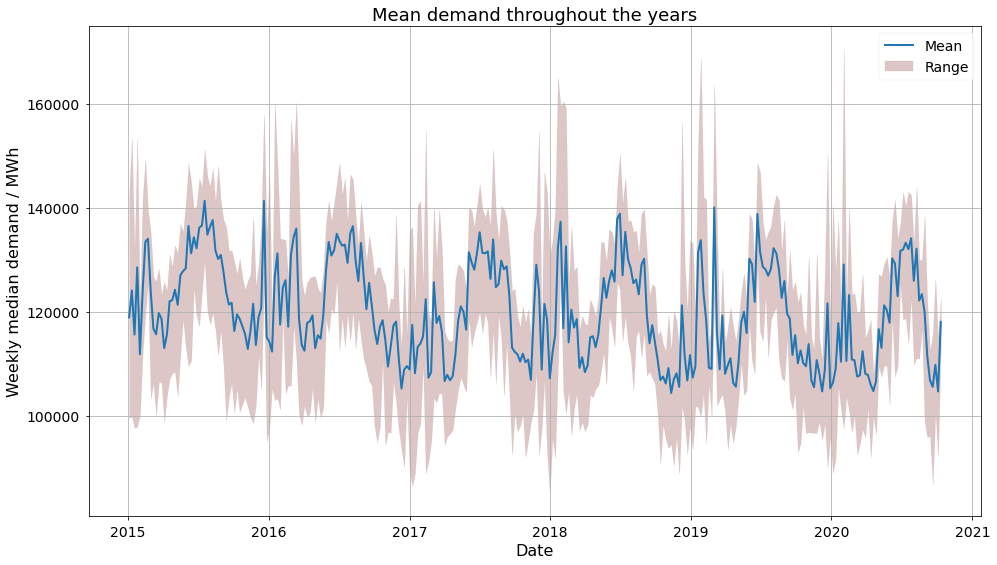

In [112]:
fig, ax = plt.subplots()
interval = '1W'
weekly_median = df.resample(interval).demand.mean()
weekly_max = df.resample(interval).demand.max()
weekly_min = df.resample(interval).demand.min()
weekly_std = df.resample(interval).demand.std()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Mean')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.5, color = 'rosybrown', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.5,  color = 'rosybrown')

ax.set_title('Mean demand throughout the years')
ax.set_ylabel('Weekly median demand / MWh')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)

### Demand per month
- The mean demand increases during June, July and August because these are within the winter season.

- Days are shorter(more lighting required), the environment is colder(more electrical heating required)


Text(0.5, 0, 'Month')

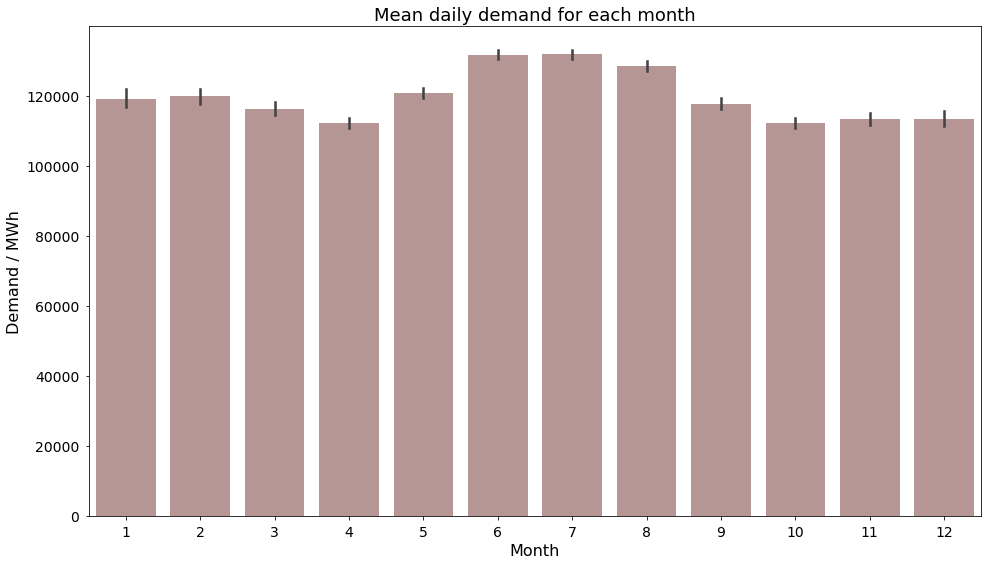

In [113]:
ax = sns.barplot(data = df, y = 'demand', x = 'month', color = 'rosybrown')
ax.set_title('Mean daily demand for each month')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Month')

Text(0.5, 0, 'Year')

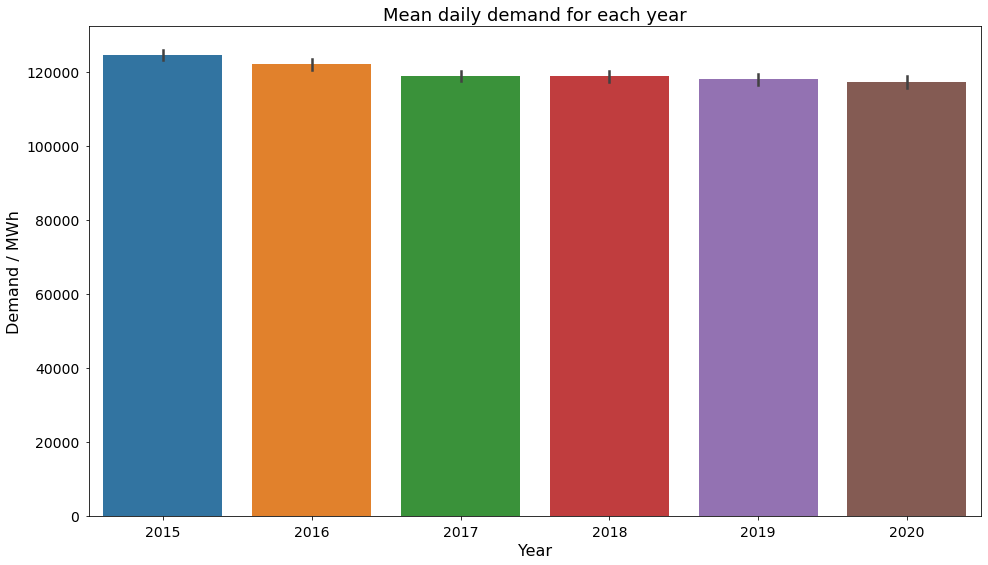

In [114]:
ax = sns.barplot(data = df, y = 'demand', x = 'year')
ax.set_title('Mean daily demand for each year')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Year')

## Price over time

In [115]:
df.groupby('year').price.agg(['mean', 'std'])

,mean,std
year,,
2015,35.068136,14.198412
2016,50.094252,39.770899
2017,94.740161,26.955444
2018,94.648823,75.567797
2019,117.281370,247.196469
2020,61.266055,176.365247


Text(0, 0.5, 'Price / AUD/MWh')

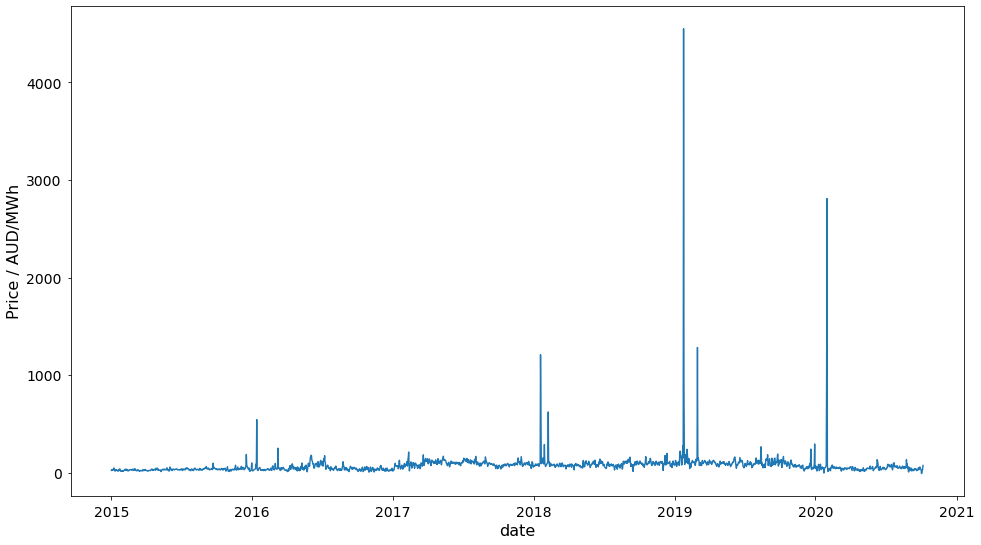

In [116]:
ax = sns.lineplot(data = df, x = 'date', y = 'price')
ax.set_ylabel('Price / AUD/MWh')

How did prices change throughout the years?

Three main events

Although the price is affected by other events too, the main ones that have made it shift throughout these years are outlined below.

### Hazelwood coal factory decommissioned

- <a href="https://en.wikipedia.org/wiki/Hazelwood_Power_Station">The hazelwood coal station</a> was closed in an effort by the country to transition to more enviromental friendly energy sources of electricity. 
- This made the price of electricity to step up.

### Australia experiences temperature peaks

- <a href="https://wattclarity.com.au/articles/2019/01/my-first-look-at-the-highs-and-lows-in-victoria-and-south-australia-on-thursday-24th-january-2019/">The country</a> experienced it's highest temperatures at least since 2015 during this period. 
- This has made electricity demand rise and surely prices too(see demand and price correlation down). 
- Demand rises because people use electricity to cool themselves(through air conditioning for example).

### The corona virus makes prices fall more

- Although prices had already started to decline a little, the pandemic has further increased it's downfall.

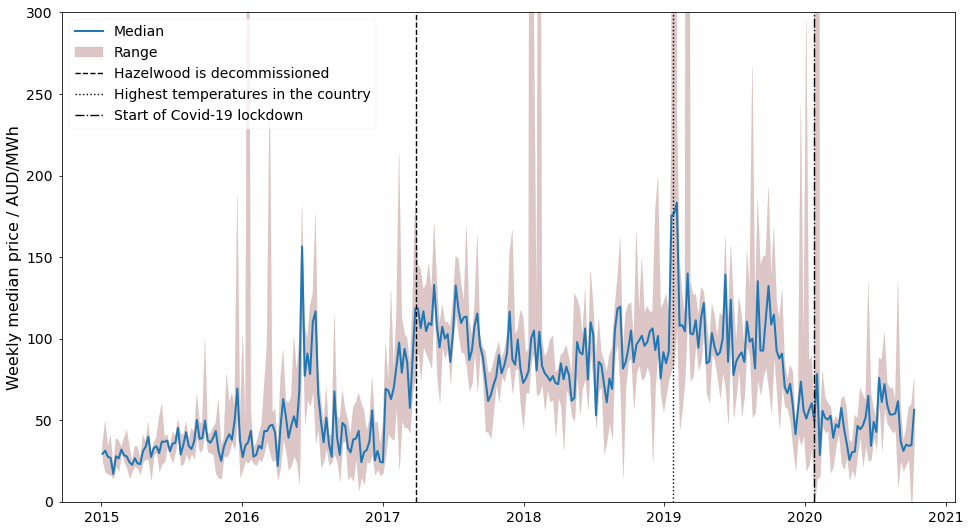

In [117]:
fig, ax = plt.subplots()
interval = '1W'
weekly_median = df.resample(interval).price.median()
weekly_max = df.resample(interval).price.max()
weekly_min = df.resample(interval).price.min()
weekly_mad = df.resample(interval).price.mad()
weekly_std = df.resample(interval).price.std()

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Median')
ax.fill_between(weekly_median.index, weekly_max, weekly_median, alpha = 0.5, color = 'rosybrown', label = 'Range')
ax.fill_between(weekly_median.index, weekly_min, weekly_median, alpha = 0.5,  color = 'rosybrown')

ax.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood is decommissioned')
ax.axvline(pd.Timestamp('2019-1-24'), ls = ':', c = 'k', label = 'Highest temperatures in the country')
ax.axvline(pd.Timestamp('2020-1-25'), ls = '-.', c = 'k', label = 'Start of Covid-19 lockdown')

ax.set_ylabel('Weekly median price / AUD/MWh')
ax.set_ylim([0, 300])
ax.legend()

Text(0.5, 0, 'Year')

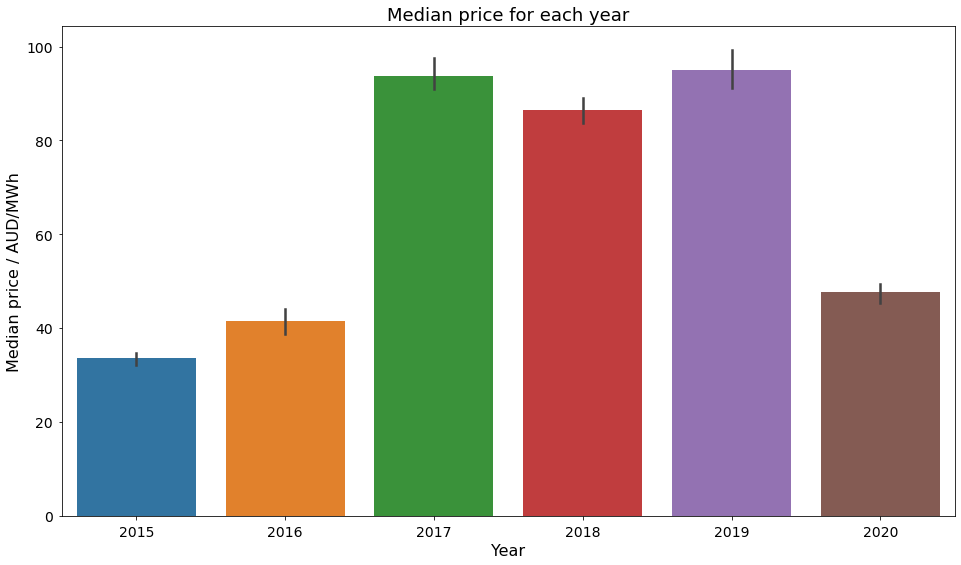

In [118]:
ax = sns.barplot(data = df, y = 'price', x = 'year', estimator = np.median)
ax.set_title('Median price for each year')
ax.set_ylabel('Median price / AUD/MWh')
ax.set_xlabel('Year')

<AxesSubplot:xlabel='year', ylabel='price'>

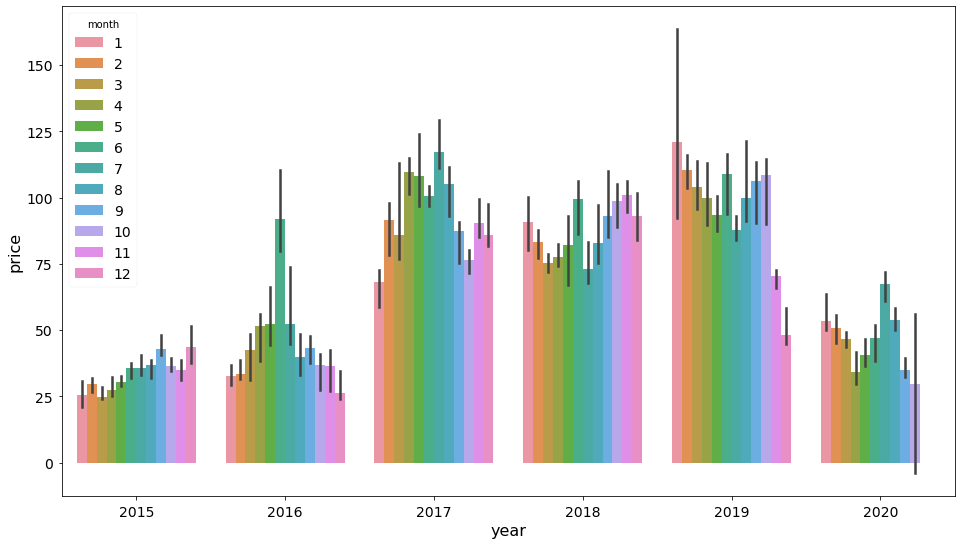

In [119]:
sns.barplot(data = df, y = 'price', x = 'year', hue = 'month', estimator = np.median)

Patterns in prices per seasons and months of the year.

### Variation in price per month on average
According to this graph, the prices in January(<a href="http://www.bom.gov.au/climate/glossary/seasons.shtml">the hot summer</a>) should be greater than during the rest of the year. Let's not forget that Australia had it's greatest temperatures in January 2019 and these have affected this graph.

<p>We can say that during the months of:</p>
<p style="text-indent:10px">January(Summer season in general)</p>
<p style="text-indent:10px">July and August(Winter season in general)</p><br>
prices will usually rise. <br>
<br>
Because electricity is being heavily used to cool down or heat up living spaces according to the season.

Text(0, 0.5, 'Price relative to yearly mean')

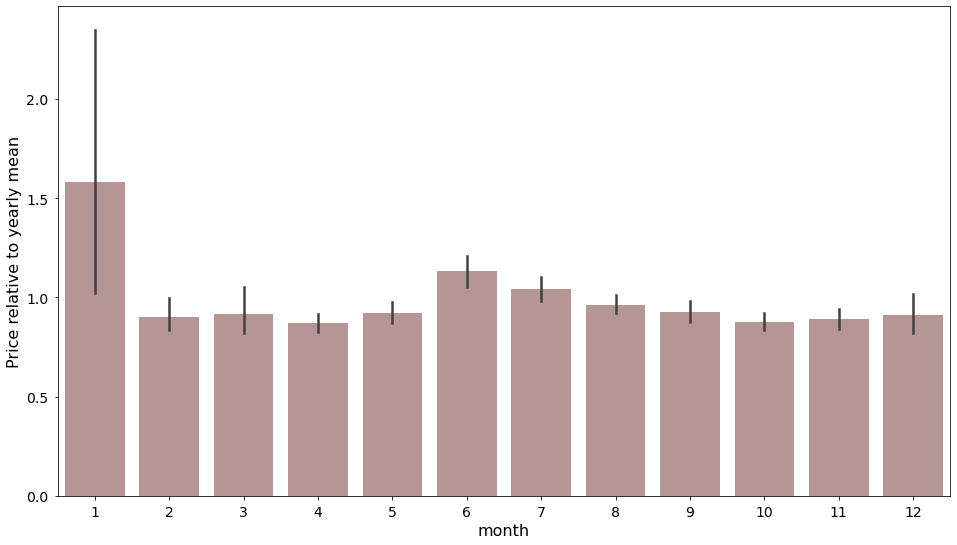

In [120]:
yearly_means = df.groupby('year').price.mean().to_frame('mean_yearly_price')
df_temp = df.copy()
df_temp = df_temp.merge(yearly_means, on = 'year')
df_temp['relative_price'] = df_temp.price/df_temp.mean_yearly_price

ax = sns.barplot(data = df_temp, y = 'relative_price', x = 'month', estimator = np.mean, color = 'rosybrown')
ax.set_ylabel('Price relative to yearly mean')

We should also be ready for periods when prices will skyrocket. 
These are periods when the temperatures are the highest.

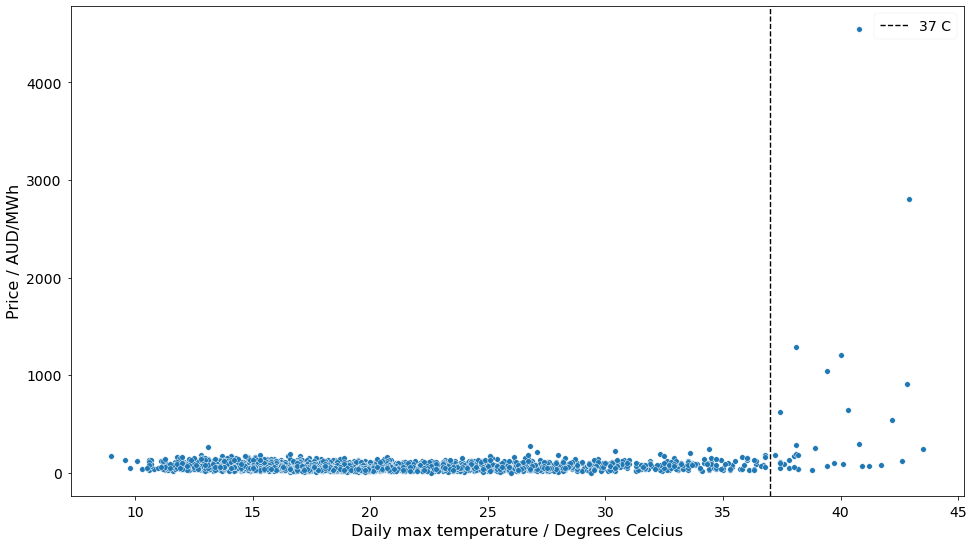

In [121]:
ax = sns.scatterplot(data = df, x = 'max_temperature', y = 'price')
ax.set_ylabel('Price / AUD/MWh')
ax.set_xlabel('Daily max temperature / Degrees Celcius')
ax.axvline(37, ls = '--', c = 'k', label = r'37 C')
ax.legend()

## Temperature over time

The peak at the beginning of 2019 coincides with prices rising as we mentioned earlier

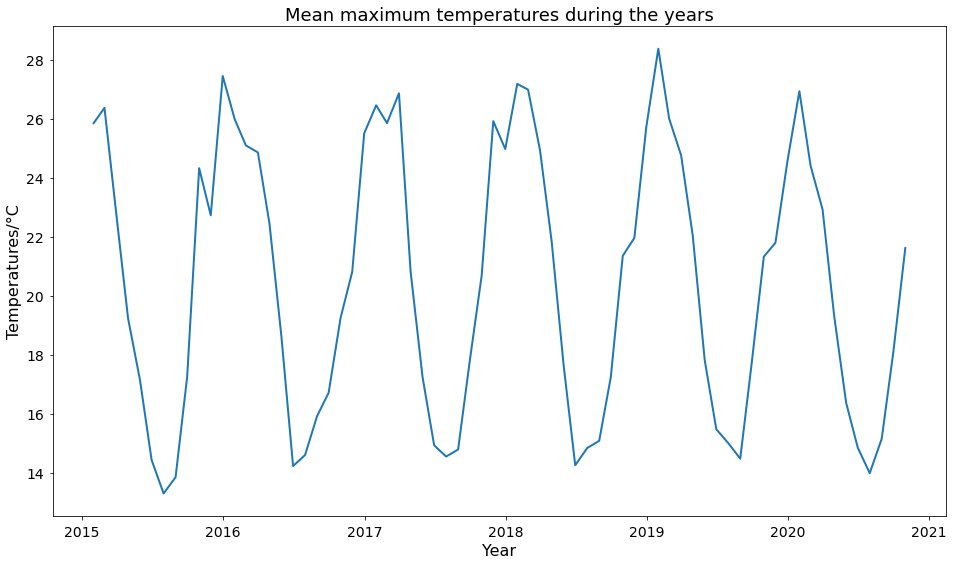

In [122]:
fig, ax = plt.subplots()
interval = '1M'
weekly_median = df.resample(interval).max_temperature.mean()
ax.set_title('Mean maximum temperatures during the years')
ax.set_ylabel('Temperatures/°C')
ax.set_xlabel('Year')

ax.plot(weekly_median.index, weekly_median, lw = 2, label = 'Median')


In [123]:
df.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,year,month,dow
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000,2106.000000,2106.000000,2106.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944,2017.398386,6.336182,3.000475
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897,1.665174,3.388396,2.000831
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000,2015.000000,1.000000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000,2016.000000,3.000000,1.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000,2017.000000,6.000000,3.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000,2019.000000,9.000000,5.000000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000,2020.000000,12.000000,6.000000


### Solar exposure over time
- In the middle of the year during the winter, solar exposure is lowest while demand is highest
- Vice versa, when solar exposure is highest during summer, demand is usually at its lowest.

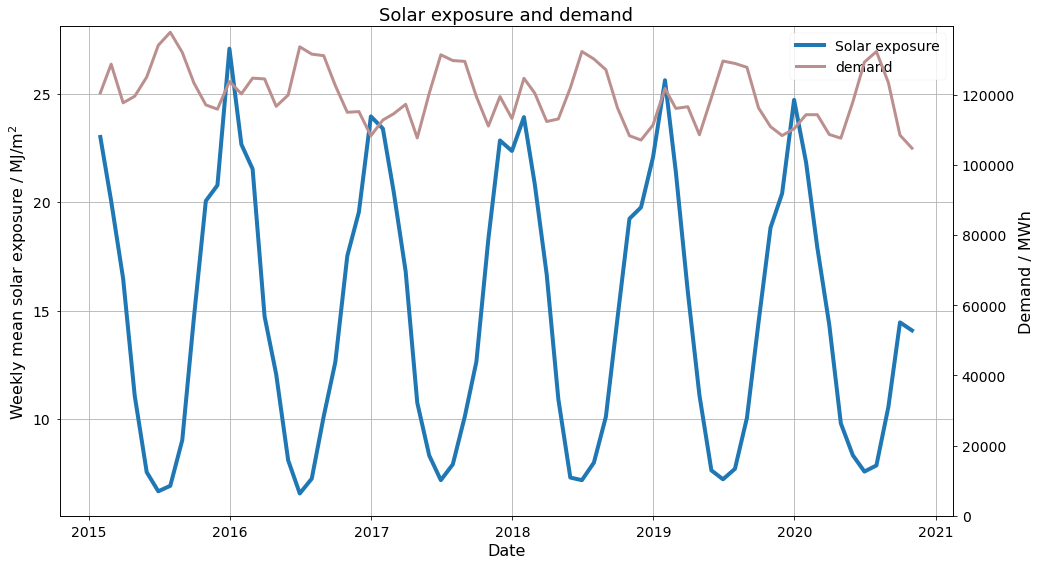

In [124]:
fig, ax = plt.subplots()
interval = '1M'
weekly_median = df.resample(interval).solar_exposure.mean()
weekly_max = df.resample(interval).solar_exposure.max()
weekly_min = df.resample(interval).solar_exposure.min()
weekly_std = df.resample(interval).solar_exposure.std()

ax.plot(weekly_median.index, weekly_median, lw = 4, label = 'Solar exposure')

interval = '1M'
weekly_median = df.resample(interval).demand.mean()
weekly_max = df.resample(interval).demand.max()
weekly_min = df.resample(interval).demand.min()
weekly_std = df.resample(interval).demand.std()

ax_twin = ax.twinx()
sns.lineplot(data = weekly_median, x = weekly_median.index, y = weekly_median, lw=3, ax = ax_twin, label = 'demand', color = 'rosybrown', legend=False)
ax_twin.set_ylim(bottom = 0)
ax_twin.set_ylabel('Demand / MWh')
lines = ax.lines + ax_twin.lines
labels = [l.get_label() for l in lines]

ax.legend(lines, labels)

ax.set_title('Solar exposure and demand')
ax.set_ylabel('Weekly mean solar exposure / MJ/m$^2$')
ax.set_xlabel('Date')
ax.grid(True)

### Demand for different weekdays and holidays

Text(0, 0.5, 'Electricity demand / MWh/Day')

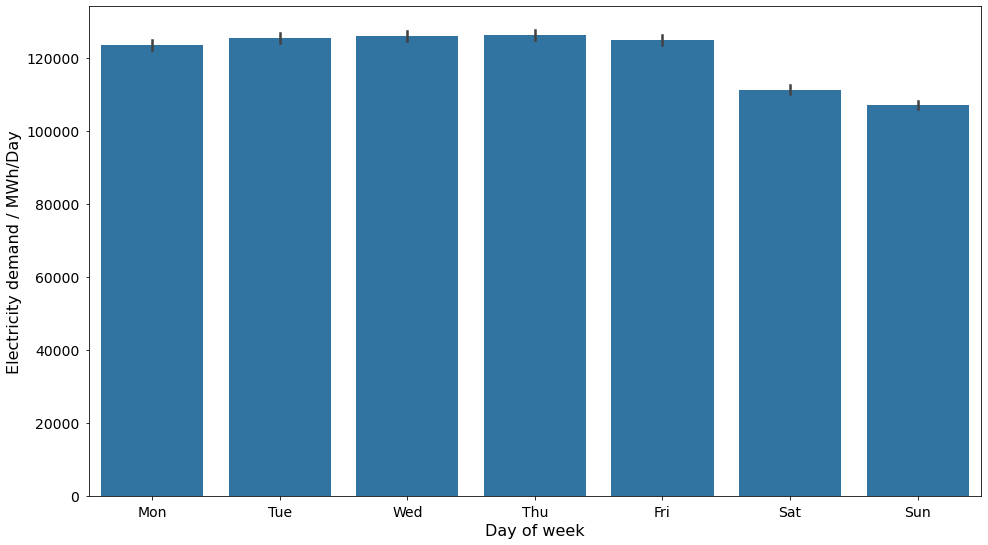

In [125]:
ax = sns.barplot(data = df[~df.holiday], x = 'dow', y = 'demand', color = 'C0')
ax.set_xticks([0,1,2,3,4,5,6],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of week')
ax.set_ylabel('Electricity demand / MWh/Day') 

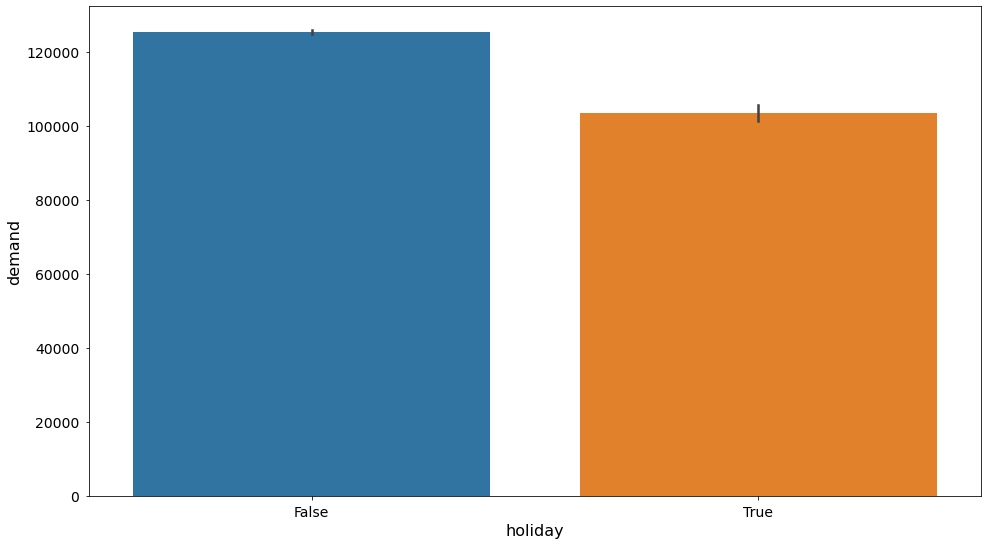

In [126]:
ax = sns.barplot(data = df[~df.dow.isin([5,6])], x = 'holiday', y = 'demand')

### Price for different weekdays and holidays

Text(0, 0.5, 'Median electricity price / AUD/MWh')

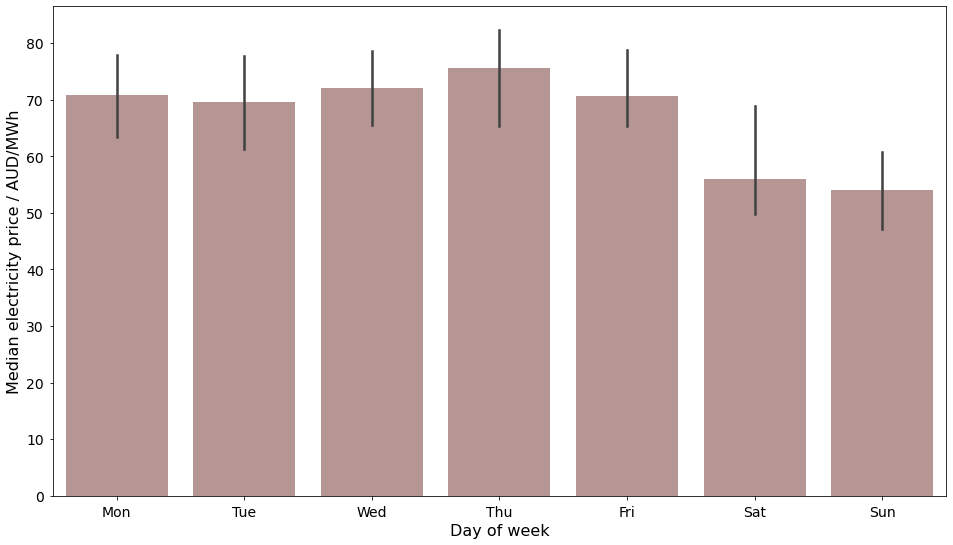

In [127]:
ax = sns.barplot(data = df[~df.holiday], x = 'dow', y = 'price', estimator=np.median, color = 'rosybrown')
ax.set_xticks([0,1,2,3,4,5,6],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_xlabel('Day of week')
ax.set_ylabel('Median electricity price / AUD/MWh') 

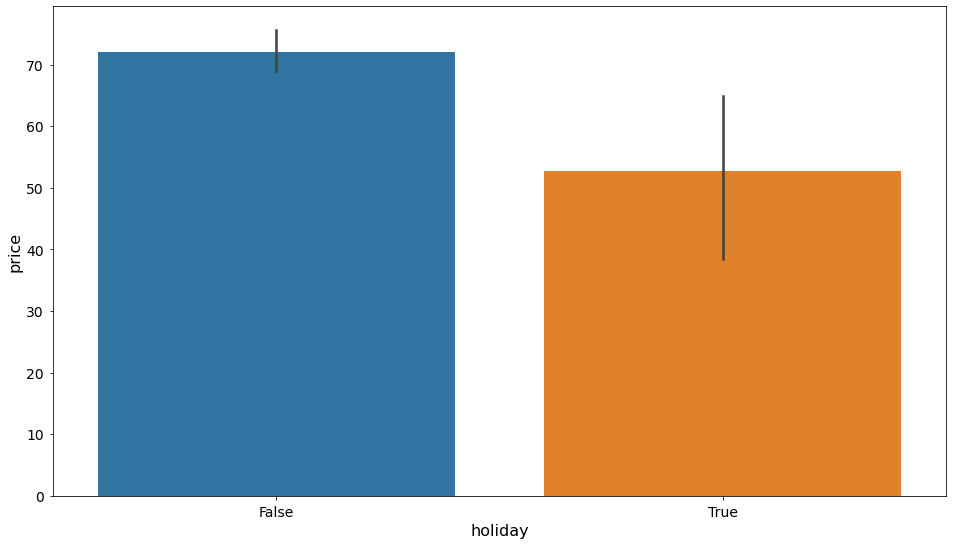

In [128]:
ax = sns.barplot(data = df[~df.dow.isin([5,6])], x = 'holiday', y = 'price', estimator = np.median)

## Correlations

In [129]:
df.corrwith(df.price)

demand              0.217538
price               1.000000
demand_pos_price    0.220856
price_positive      0.999821
demand_neg_price   -0.078815
price_negative      0.038931
frac_neg_price     -0.077955
min_temperature     0.070619
max_temperature     0.165484
solar_exposure      0.061808
rainfall           -0.028642
school_day         -0.005014
holiday            -0.030963
year                0.139880
month              -0.067947
dow                -0.030758
dtype: float64

Try removing the price outliers

In [130]:
df_no_outliers = df[df.price < 3*df.price.median()]

In [131]:
df_no_outliers.corrwith(df_no_outliers.price)

demand              0.245898
price               1.000000
demand_pos_price    0.289040
price_positive      0.997579
demand_neg_price   -0.248545
price_negative      0.116852
frac_neg_price     -0.246340
min_temperature    -0.075656
max_temperature    -0.001859
solar_exposure     -0.049369
rainfall           -0.037359
school_day          0.097267
holiday            -0.076053
year                0.337013
month               0.023184
dow                -0.137848
dtype: float64

### Temperature and price
- The greatest prices are felt during the hottest days
- Sure enough due to the air conditioning used to cool the environment.

<AxesSubplot:xlabel='max_temperature', ylabel='price'>

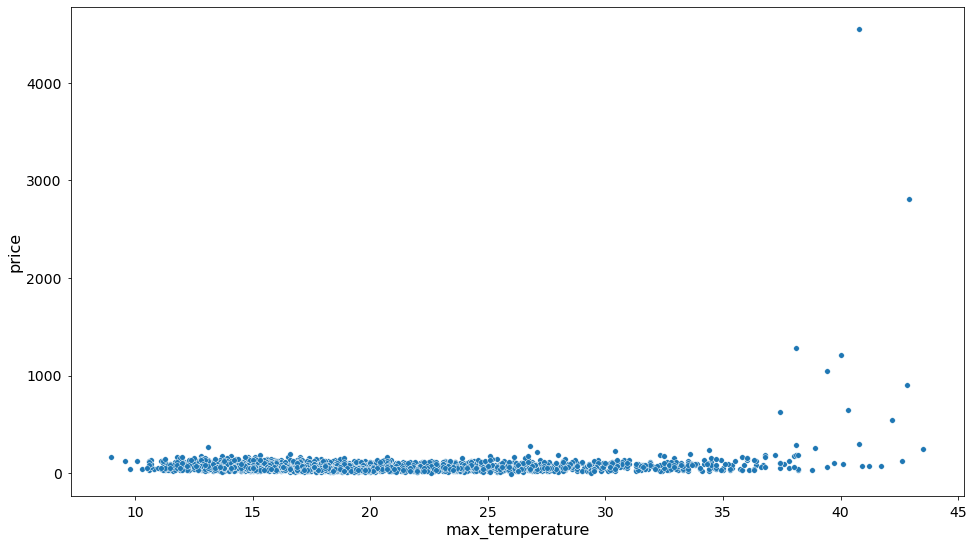

In [132]:
sns.scatterplot(data = df, x = 'max_temperature', y = 'price')

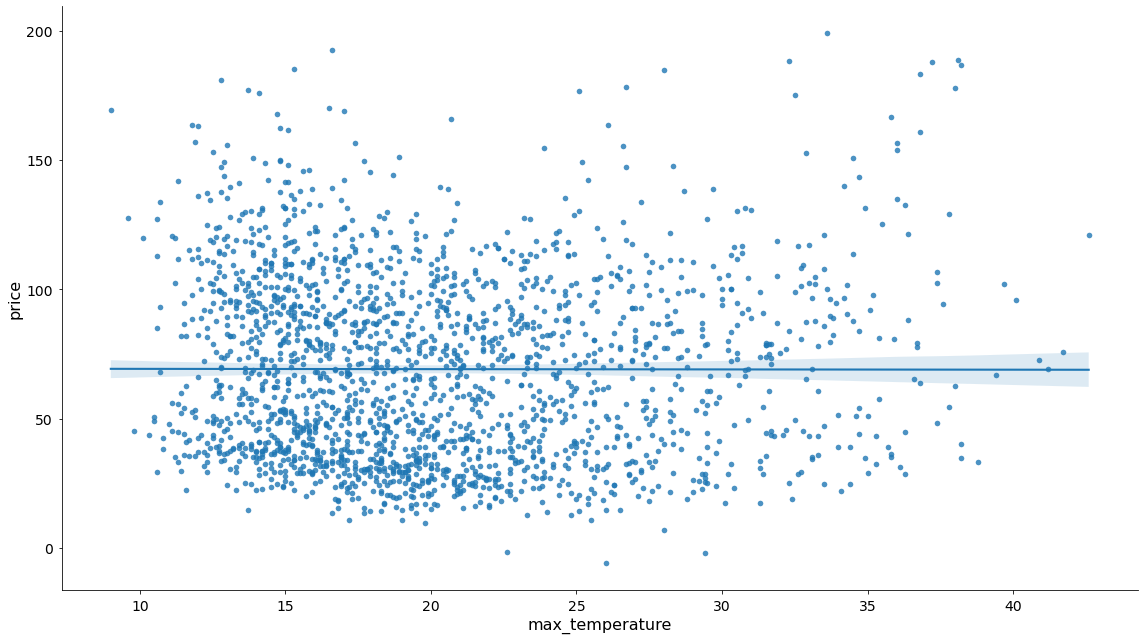

In [133]:
sns.lmplot(data = df[df.price < df.price.median()*3], x = 'max_temperature', y = 'price', height = 9, aspect = 16/9)

### Demand and price
- Price and demand are correlated.
- As the demand increases during hot seasons or during cold ones, prices will also increase.

<AxesSubplot:xlabel='demand', ylabel='price'>

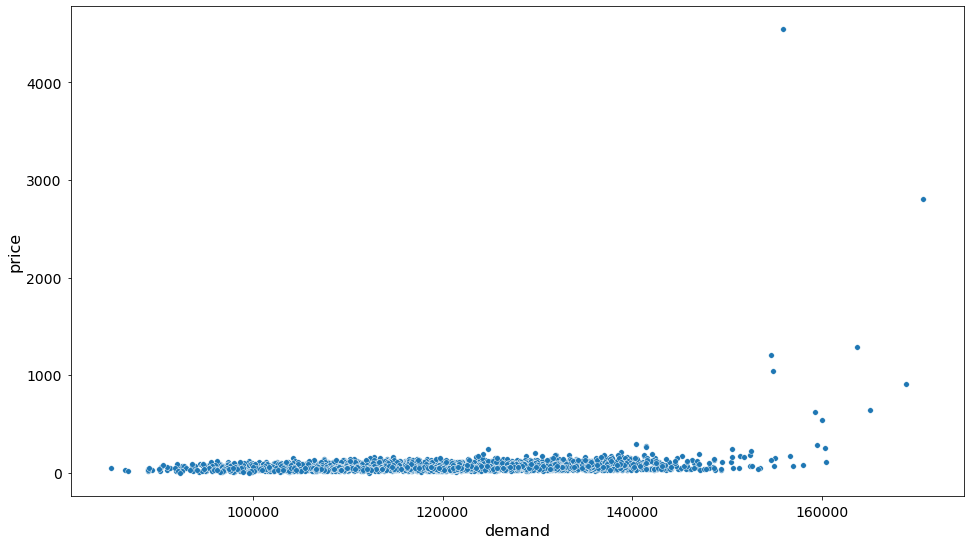

In [134]:
sns.scatterplot(data = df, x = 'demand', y = 'price')

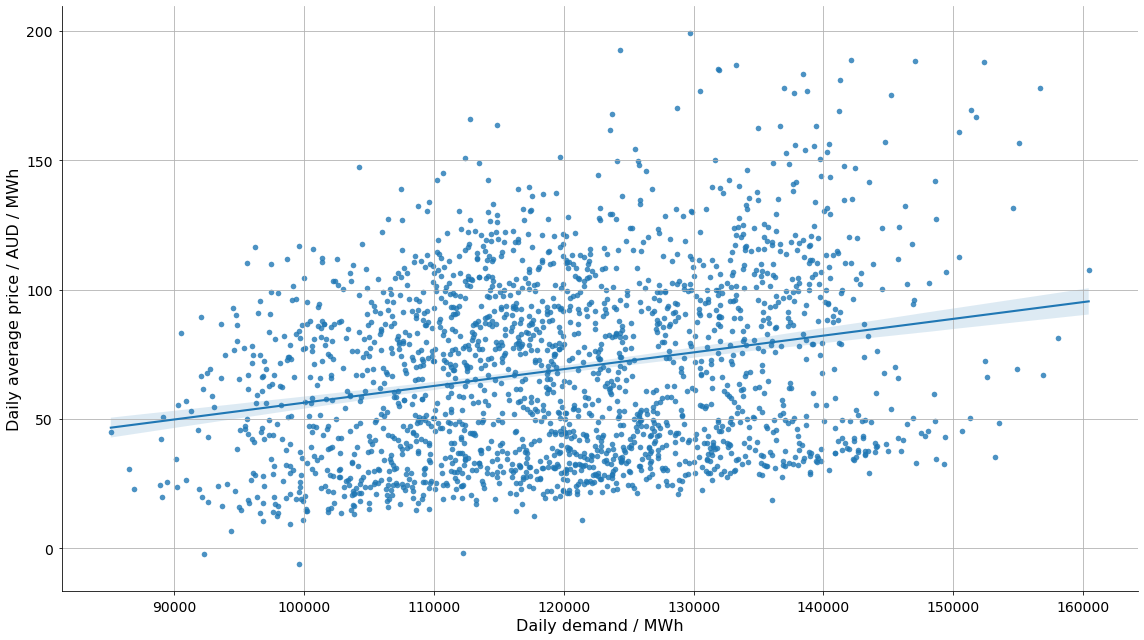

In [135]:
grid = sns.lmplot(data = df[df.price < df.price.median()*3], x = 'demand', y = 'price', height = 9, aspect = 16/9)
grid.axes[0,0].set_xlabel('Daily demand / MWh')
grid.axes[0,0].set_ylabel('Daily average price / AUD / MWh')
grid.axes[0,0].grid(True)

### Solar exposure and temperature
- This is just for fun (^_^)
- Normally solar exposure and temperature should be correlated.

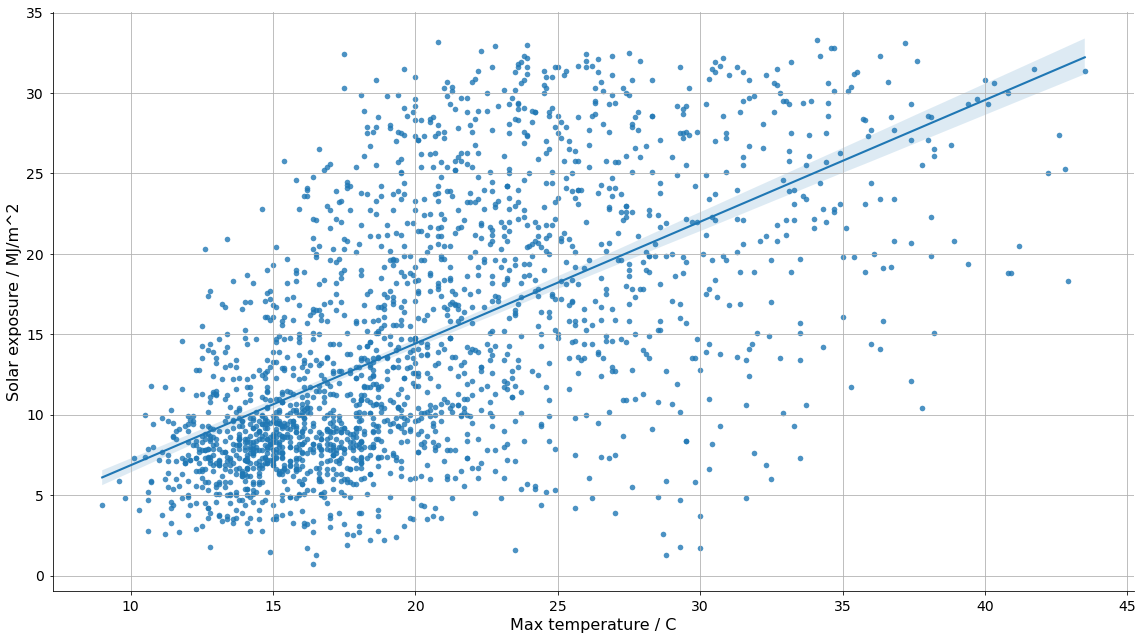

In [136]:
grid = sns.lmplot(data = df, x = 'max_temperature', y = 'solar_exposure', height = 9, aspect = 16/9)
grid.axes[0,0].set_xlabel('Max temperature / C')
grid.axes[0,0].set_ylabel('Solar exposure / MJ/m^2')
grid.axes[0,0].grid(True)